In [1]:
# Import some useful modules.
import jax
import jax.numpy as np
import os
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from '/units_constants.py' import Conversion_Factors as cf



# Import JAX-FEM specific modules.
from jax_fem.problem import Problem
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh_gmsh, get_meshio_cell_type, Mesh


       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



### Constitutive relationship
We're using SI units I have decided. 
Note to self: make unit conversion class or copy it from the 'Oumuamua code.

17/02/2025: Tested the limits of compression for sim 1. Crashed for 15%, but interestingly only once we go back up again after compressing fully to 15%. So I guess this is where the 'the cube has changed so the material responds differently now, especially to pulling'  comes into play. Rather than puling, I should unload/release. One more run with 20%, and let's see then.

And now it fails at 13%, in the compression step, for 100 iterations (in the loop). So the failing is very much a numerical thing, because why else would 15% compression work for one sim and not for another, when the only difference is step size? I did this for params1 (Y = 1, nu = 0.05, E = 100). 

19/02/2025: FOund out that stepsize matters in the PETSC_solver, and has nothing to do with $\nu$.Then found out that using jax_solver or umfpack_solver instead lets literally everything converge at 20%, for both stepsizes. So it was the solver :P, at least in part, and defo something numerical.

Also, try different solvers? So I guess the main takeaway is that the convergence issue should be looked at very carefully, and not automatically be attributed to the physics and very much also to the numerics.

## Problem class

In [2]:
class DensityError(Exception):
    pass

class Plasticity(Problem):

    def custom_init(self, dens, E_factor, nu):
        """_summary_

        Args:
            density (list, optional): the density field. Defaults to [0.0001]. Don't go over 
        """
        # ceate objects for r
        self.fe = self.fes[0]
        self.epsilons_old = np.zeros((len(self.fe.cells), self.fe.num_quads, self.fe.vec, self.dim))
        self.sigmas_old = np.zeros_like(self.epsilons_old)
        # not dens[0], but dens. Otherwise you get an array of 8 (so 1 cell) --> need to understand the use of additional args. and such properly. 
        self.density = dens 
        #print(self.density.shape)

        # these are things that can change throughout the sim
        self.internal_vars = [self.sigmas_old, self.epsilons_old, self.density]

        # elasticity coefficients
        self.E_factor = E_factor
        self.nu = nu


    def get_tensor_map(self):
        # meaning: get the tensors you want to solve for.
        # we throw away the strain and density
        _, stress_return_map = self.get_maps()
        return stress_return_map
    

    def get_maps(self):
        def safe_sqrt(x):  
            # np.sqrt is not differentiable at 0
            safe_x = np.where(x > 0., np.sqrt(x), 0.)
            return safe_x

        def safe_divide(x, y):
            return np.where(y == 0., 0., x/y)

        def strain(u_grad):
            return 0.5*(u_grad + u_grad.T)
        
        def stress(eps, E):
            return E*self.nu/((1+self.nu)*(1-2*self.nu))*np.trace(eps)*np.eye(self.dim) + 2*E/(2.*(1. + self.nu))*eps
        
        def E_calc(density):
            # question is, can I call this outside the problem?
            # no need, just set E_Factor and nu outside and then calculate again. Not efficient, but straightforward.
            return self.E_factor*density

        def P_comp(density):
            """Calculates the compressive strength of a material as a function of volume filling factor for homogeneous, monodisperse monomers. Adapted from Tatsuuma et al. 2023.
            The equation takes the density rather than volume filling factor as input. 

            Args:
                density (float, array-like): N dim. array of cell volumes

            Returns:
                float, array-like: compressive strength of each cell in the material
            """
            # C = (4*np.pi*r0**3)/(3*m0) # constant
            C = 1 # for a density varying between 0 and 1, C <= phi_max
            phi = C*density
            Y = (Eroll/(r0**3)) * (1/(C*density) - 1/phi_max)**(-3)

            return Y

        def stress_return_map(u_grad, sigma_old, eps_old, density):
            """ Calculate the new stress field from the old deformation gradient, old stress, and old strain. 

            Args:
                u_grad (_type_): 3x3 matrix, gradient of the solution
                sigma_old (_type_): 3x3 matrix of the stresses
                eps_old (_type_): 3x3 matrix of the strains
                density (_type_): scalar value of the density

            Returns:
                _type_: updated stress

            """
    
            # calculate the yield strength and Young's modulus from the density field
            Y = P_comp(density)
            E = E_calc(density) # E = constant * density
            
            # calculate the new stress field with a radial return map
            deps = strain(u_grad) - eps_old
            sigma_trial = stress(deps, E) + sigma_old
            s_dev = sigma_trial - 1./self.dim*np.trace(sigma_trial)*np.eye(self.dim)
            von_Mises = safe_sqrt(3./2.*np.sum(s_dev*s_dev))
            f_yield = von_Mises - Y
            f_yield_plus = np.where(f_yield > 0., f_yield, 0.)
            sigma = sigma_trial - safe_divide(f_yield_plus*s_dev,von_Mises)

            return sigma
        
        return strain, stress_return_map
    
    def stress_strain_funcs(self):
        """Return mapping functions for stress, strain, density

        Returns:
            _type_: _description_
        """
        strain, stress_return_map = self.get_maps()
        vmap_strain = jax.vmap(jax.vmap(strain))
        vmap_stress_return_map = jax.vmap(jax.vmap(stress_return_map))
        return vmap_strain, vmap_stress_return_map
        

    def update_stress_strain_density(self, sol, density):
        # set new values for old stress, strain, density
        u_grads = self.fe.sol_to_grad(sol)
        vmap_strain, vmap_stress_rm = self.stress_strain_funcs()
        self.density = density
        self.sigmas_old = vmap_stress_rm(u_grads, self.sigmas_old, self.epsilons_old, self.density) # use old or new density? I think old
        self.epsilons_old = vmap_strain(u_grads)
        self.internal_vars = [self.sigmas_old, self.epsilons_old, self.density]
        print(self.density.shape, self.sigmas_old.shape, self.epsilons_old.shape)


    def compute_avg_stress(self):
        # For post-processing only: Compute volume averaged stress.
        # (num_cells*num_quads, vec, dim) * (num_cells*num_quads, 1, 1) -> (vec, dim)
        sigma = np.sum(self.sigmas_old.reshape(-1, self.fe.vec, self.dim) * self.fe.JxW.reshape(-1)[:, None, None], 0)
        vol = np.sum(self.fe.JxW)
        avg_sigma = sigma/vol
        return avg_sigma


### Simulation

[03-07 18:28:26][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[03-07 18:28:26][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[03-07 18:28:26][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[03-07 18:28:26][DEBUG] jax_fem: Done pre-computations, took 0.053597450256347656 [s]
[03-07 18:28:26][INFO] jax_fem: Solving a problem with 1000 cells, 1331x3 = 3993 dofs.
[03-07 18:28:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:26][DEBUG] jax_fem: Start timing
[03-07 18:28:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Extruded)
Info    : [ 10%] Meshing curve 2 (Extruded)
Info    : [ 20%] Meshing curve 3 (Extruded)
Info    : [ 30%] Meshing curve 4 (Extruded)
Info    : [ 40%] Meshing curve 7 (Extruded)
Info    : [ 50%] Meshing curve 8 (Extruded)
Info    : [ 50%] Meshing curve 9 (Extruded)
Info    : [ 60%] Meshing curve 10 (Extruded)
Info    : [ 70%] Meshing curve 12 (Extruded)
Info    : [ 80%] Meshing curve 13 (Extruded)
Info    : [ 90%] Meshing curve 17 (Extruded)
Info    : [100%] Meshing curve 21 (Extruded)
Info    : Done meshing 1D (Wall 0.000175081s, CPU 0.000161s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 20%] Meshing surface 14 (Extruded)
Info    : [ 40%] Meshing surface 18 (Extruded)
Info    : [ 50%] Meshing surface 22 (Extruded)
Info    : [ 70%] Meshing surface 26 (Extruded)
Info    : [ 90%] Meshing surface 27 (Extruded)
Info    : Done meshing 2D (Wall 0.00807336s, CPU 0.009687s)
Info    : Meshing

[03-07 18:28:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.4401 seconds
[03-07 18:28:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:27][DEBUG] jax_fem: Before, l_2 res = 0.0, relative l_2 res = nan
[03-07 18:28:27][INFO] jax_fem: Solve took 0.511481761932373 [s]
[03-07 18:28:27][DEBUG] jax_fem: max of dofs = 0.0
[03-07 18:28:27][DEBUG] jax_fem: min of dofs = 0.0
[03-07 18:28:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:28][DEBUG] jax_fem: Start timing
[03-07 18:28:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.1063 seconds
[03-07 18:28:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:28][DEBUG] jax_fem: Before, l_2 res = 0.4631578947368421, relative l_2 res = 1.0
[03-07 18:28:28][DEBUG] jax_fem: Solving linear system...


(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 1 in 20, disp = -0.042105263157894736


[03-07 18:28:28][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:29][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 9.645850820455592e-11
[03-07 18:28:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.1368 seconds
[03-07 18:28:29][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:29][DEBUG] jax_fem: l_2 res = 9.645850820409067e-11, relative l_2 res = 2.0826268816792305e-10
[03-07 18:28:29][INFO] jax_fem: Solve took 0.9453048706054688 [s]
[03-07 18:28:29][DEBUG] jax_fem: max of dofs = 0.0018439816479034299
[03-07 18:28:29][DEBUG] jax_fem: min of dofs = -0.042105263157894736
[03-07 18:28:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:30][DEBUG] jax_fem: Start timing
[03-07 18:28:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.1110

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 2 in 20, disp = -0.08421052631578947


[03-07 18:28:30][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:31][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 4.2574518010279954e-11
[03-07 18:28:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.1276 seconds
[03-07 18:28:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:31][DEBUG] jax_fem: l_2 res = 4.257451801035796e-11, relative l_2 res = 4.596112739754553e-11
[03-07 18:28:31][INFO] jax_fem: Solve took 0.8672616481781006 [s]
[03-07 18:28:31][DEBUG] jax_fem: max of dofs = 0.003633352606963305
[03-07 18:28:31][DEBUG] jax_fem: min of dofs = -0.08421052631578947
[03-07 18:28:32][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:32][DEBUG] jax_fem: Start timing
[03-07 18:28:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.1295 s

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 3 in 20, disp = -0.12631578947368421


[03-07 18:28:33][DEBUG] jax_fem: Before, l_2 res = 1.3894736842105382, relative l_2 res = 1.0
[03-07 18:28:33][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:33][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:33][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 1.2093433370492622e-10
[03-07 18:28:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.1355 seconds
[03-07 18:28:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:33][DEBUG] jax_fem: l_2 res = 1.2093433370358854e-10, relative l_2 res = 8.703607349879404e-11
[03-07 18:28:33][INFO] jax_fem: Solve took 0.9788050651550293 [s]
[03-07 18:28:33][DEBUG] jax_fem: max of dofs = 0.005393831607961053
[03-07 18:28:33][DEBUG] jax_fem: min of dofs = -0.12631578947368421
[03-07 18:28:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:34][DEBUG] jax_fem: Start timing
[03

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 4 in 20, disp = -0.16842105263157894


[03-07 18:28:35][DEBUG] jax_fem: Before, l_2 res = 1.852631578947464, relative l_2 res = 1.0
[03-07 18:28:35][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:35][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:35][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 1.8426549753070053e-10
[03-07 18:28:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.1314 seconds
[03-07 18:28:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:35][DEBUG] jax_fem: l_2 res = 1.8426549753094281e-10, relative l_2 res = 9.946149014453786e-11
[03-07 18:28:35][INFO] jax_fem: Solve took 0.9187362194061279 [s]
[03-07 18:28:35][DEBUG] jax_fem: max of dofs = 0.007121058868761994
[03-07 18:28:35][DEBUG] jax_fem: min of dofs = -0.16842105263157894
[03-07 18:28:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:37][DEBUG] jax_fem: Start timing
[03-

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 5 in 20, disp = -0.21052631578947367


[03-07 18:28:37][DEBUG] jax_fem: Before, l_2 res = 2.315789473684582, relative l_2 res = 1.0
[03-07 18:28:37][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:37][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:37][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 2.1923691137390109e-10
[03-07 18:28:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.1257 seconds
[03-07 18:28:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:38][DEBUG] jax_fem: l_2 res = 2.1923691137639516e-10, relative l_2 res = 9.467048445797364e-11
[03-07 18:28:38][INFO] jax_fem: Solve took 0.8333098888397217 [s]
[03-07 18:28:38][DEBUG] jax_fem: max of dofs = 0.00881196624931281
[03-07 18:28:38][DEBUG] jax_fem: min of dofs = -0.21052631578947367
[03-07 18:28:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:39][DEBUG] jax_fem: Start timing
[03-0

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 6 in 20, disp = -0.25263157894736843


[03-07 18:28:39][DEBUG] jax_fem: Before, l_2 res = 2.7789473684221067, relative l_2 res = 1.0
[03-07 18:28:39][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:39][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:39][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 2.245494518147725e-10
[03-07 18:28:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.1346 seconds
[03-07 18:28:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:40][DEBUG] jax_fem: l_2 res = 2.2454945181744898e-10, relative l_2 res = 8.080378001003621e-11
[03-07 18:28:40][INFO] jax_fem: Solve took 0.9409022331237793 [s]
[03-07 18:28:40][DEBUG] jax_fem: max of dofs = 0.010463912332525305
[03-07 18:28:40][DEBUG] jax_fem: min of dofs = -0.25263157894736843
[03-07 18:28:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:41][DEBUG] jax_fem: Start timing
[03-

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 7 in 20, disp = -0.29473684210526313


[03-07 18:28:41][DEBUG] jax_fem: Before, l_2 res = 3.242105263160417, relative l_2 res = 1.0
[03-07 18:28:41][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:41][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:42][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 3.012447056597306e-10
[03-07 18:28:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.1292 seconds
[03-07 18:28:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:42][DEBUG] jax_fem: l_2 res = 3.0124470565843314e-10, relative l_2 res = 9.291638648548339e-11
[03-07 18:28:42][INFO] jax_fem: Solve took 0.8461806774139404 [s]
[03-07 18:28:42][DEBUG] jax_fem: max of dofs = 0.012073180301182233
[03-07 18:28:42][DEBUG] jax_fem: min of dofs = -0.29473684210526313
[03-07 18:28:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:43][DEBUG] jax_fem: Start timing
[03-0

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 8 in 20, disp = -0.3368421052631579


[03-07 18:28:43][DEBUG] jax_fem: Before, l_2 res = 3.705263157900176, relative l_2 res = 1.0
[03-07 18:28:43][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:43][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:44][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 3.3663289659323783e-10
[03-07 18:28:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.1321 seconds
[03-07 18:28:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:44][DEBUG] jax_fem: l_2 res = 3.366328965777745e-10, relative l_2 res = 9.085262833761827e-11
[03-07 18:28:44][INFO] jax_fem: Solve took 0.9448716640472412 [s]
[03-07 18:28:44][DEBUG] jax_fem: max of dofs = 0.013636064766651001
[03-07 18:28:44][DEBUG] jax_fem: min of dofs = -0.3368421052631579
[03-07 18:28:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:45][DEBUG] jax_fem: Start timing
[03-07

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 9 in 20, disp = -0.37894736842105264


[03-07 18:28:46][DEBUG] jax_fem: Before, l_2 res = 4.168421052642537, relative l_2 res = 1.0
[03-07 18:28:46][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:46][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:46][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 2.6671538612115807e-10
[03-07 18:28:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.1262 seconds
[03-07 18:28:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:46][DEBUG] jax_fem: l_2 res = 2.6671538608774814e-10, relative l_2 res = 6.398475171280167e-11
[03-07 18:28:46][INFO] jax_fem: Solve took 0.8499190807342529 [s]
[03-07 18:28:46][DEBUG] jax_fem: max of dofs = 0.015149214216644448
[03-07 18:28:46][DEBUG] jax_fem: min of dofs = -0.37894736842105264
[03-07 18:28:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:48][DEBUG] jax_fem: Start timing
[03-

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 10 in 20, disp = -0.42105263157894735


[03-07 18:28:48][DEBUG] jax_fem: Before, l_2 res = 4.631578947389532, relative l_2 res = 1.0
[03-07 18:28:48][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:48][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:48][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 2.922456087446146e-10
[03-07 18:28:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.1268 seconds
[03-07 18:28:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:48][DEBUG] jax_fem: l_2 res = 2.9224560872375563e-10, relative l_2 res = 6.309848370143236e-11
[03-07 18:28:48][INFO] jax_fem: Solve took 0.9112129211425781 [s]
[03-07 18:28:48][DEBUG] jax_fem: max of dofs = 0.01660626660818843
[03-07 18:28:48][DEBUG] jax_fem: min of dofs = -0.42105263157894735
[03-07 18:28:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:50][DEBUG] jax_fem: Start timing
[03-07

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 11 in 20, disp = -0.4631578947368421


[03-07 18:28:50][DEBUG] jax_fem: Before, l_2 res = 5.094736842144803, relative l_2 res = 1.0
[03-07 18:28:50][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:50][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:51][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 2.437020045816839e-10
[03-07 18:28:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.1361 seconds
[03-07 18:28:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:51][DEBUG] jax_fem: l_2 res = 2.4370200456533513e-10, relative l_2 res = 4.7834071143651154e-11
[03-07 18:28:51][INFO] jax_fem: Solve took 0.9399139881134033 [s]
[03-07 18:28:51][DEBUG] jax_fem: max of dofs = 0.01800288029580023
[03-07 18:28:51][DEBUG] jax_fem: min of dofs = -0.4631578947368421
[03-07 18:28:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:52][DEBUG] jax_fem: Start timing
[03-07

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 12 in 20, disp = -0.5052631578947369


[03-07 18:28:52][DEBUG] jax_fem: Before, l_2 res = 5.557894736915009, relative l_2 res = 1.0
[03-07 18:28:52][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:52][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:53][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 5.047028406985095e-10
[03-07 18:28:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.1355 seconds
[03-07 18:28:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:53][DEBUG] jax_fem: l_2 res = 5.047028406972309e-10, relative l_2 res = 9.080827626062124e-11
[03-07 18:28:53][INFO] jax_fem: Solve took 0.8628392219543457 [s]
[03-07 18:28:53][DEBUG] jax_fem: max of dofs = 0.019333277573336027
[03-07 18:28:53][DEBUG] jax_fem: min of dofs = -0.5052631578947369
[03-07 18:28:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:54][DEBUG] jax_fem: Start timing
[03-07 

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 13 in 20, disp = -0.5473684210526316


[03-07 18:28:54][DEBUG] jax_fem: Before, l_2 res = 6.021052631712721, relative l_2 res = 1.0
[03-07 18:28:54][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:54][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:55][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 5.501088614841269e-10
[03-07 18:28:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.1400 seconds
[03-07 18:28:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:55][DEBUG] jax_fem: l_2 res = 5.50108861542526e-10, relative l_2 res = 9.136423399541758e-11
[03-07 18:28:55][INFO] jax_fem: Solve took 0.8542578220367432 [s]
[03-07 18:28:55][DEBUG] jax_fem: max of dofs = 0.020590111482255306
[03-07 18:28:55][DEBUG] jax_fem: min of dofs = -0.5473684210526316
[03-07 18:28:56][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:56][DEBUG] jax_fem: Start timing
[03-07 1

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 14 in 20, disp = -0.5894736842105263


[03-07 18:28:56][DEBUG] jax_fem: Before, l_2 res = 6.484210526562615, relative l_2 res = 1.0
[03-07 18:28:56][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:56][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:57][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 4.4863271397240426e-10
[03-07 18:28:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:57][DEBUG] jax_fem: Function split_and_compute_cell took 0.1356 seconds
[03-07 18:28:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:57][DEBUG] jax_fem: l_2 res = 4.4863271400009816e-10, relative l_2 res = 6.918848673439442e-11
[03-07 18:28:57][INFO] jax_fem: Solve took 0.8923518657684326 [s]
[03-07 18:28:57][DEBUG] jax_fem: max of dofs = 0.0217658343986765
[03-07 18:28:57][DEBUG] jax_fem: min of dofs = -0.5894736842105263
[03-07 18:28:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:28:58][DEBUG] jax_fem: Start timing
[03-07 

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 15 in 20, disp = -0.631578947368421


[03-07 18:28:59][DEBUG] jax_fem: Before, l_2 res = 6.947368421515632, relative l_2 res = 1.0
[03-07 18:28:59][DEBUG] jax_fem: Solving linear system...
[03-07 18:28:59][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:28:59][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 5.371905629074676e-10
[03-07 18:28:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:28:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.1237 seconds
[03-07 18:28:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:28:59][DEBUG] jax_fem: l_2 res = 5.371905629098362e-10, relative l_2 res = 7.732288405005059e-11
[03-07 18:28:59][INFO] jax_fem: Solve took 0.9100711345672607 [s]
[03-07 18:28:59][DEBUG] jax_fem: max of dofs = 0.02285151523412806
[03-07 18:28:59][DEBUG] jax_fem: min of dofs = -0.631578947368421
[03-07 18:29:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:29:00][DEBUG] jax_fem: Start timing
[03-07 18

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 16 in 20, disp = -0.6736842105263158


[03-07 18:29:01][DEBUG] jax_fem: Before, l_2 res = 7.410526316684006, relative l_2 res = 1.0
[03-07 18:29:01][DEBUG] jax_fem: Solving linear system...
[03-07 18:29:01][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:29:01][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 7.313870628104371e-10
[03-07 18:29:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:29:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.1364 seconds
[03-07 18:29:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:29:01][DEBUG] jax_fem: l_2 res = 7.313870628183255e-10, relative l_2 res = 9.86956973854456e-11
[03-07 18:29:01][INFO] jax_fem: Solve took 0.9451563358306885 [s]
[03-07 18:29:01][DEBUG] jax_fem: max of dofs = 0.023836824259750443
[03-07 18:29:01][DEBUG] jax_fem: min of dofs = -0.6736842105263158
[03-07 18:29:03][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:29:03][DEBUG] jax_fem: Start timing
[03-07 1

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 17 in 20, disp = -0.7157894736842105


[03-07 18:29:03][DEBUG] jax_fem: Before, l_2 res = 7.873684212337196, relative l_2 res = 1.0
[03-07 18:29:03][DEBUG] jax_fem: Solving linear system...
[03-07 18:29:03][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:29:03][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 5.802973313890437e-10
[03-07 18:29:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:29:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.1366 seconds
[03-07 18:29:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:29:03][DEBUG] jax_fem: l_2 res = 5.80297331369903e-10, relative l_2 res = 7.37008642613125e-11
[03-07 18:29:03][INFO] jax_fem: Solve took 0.8907754421234131 [s]
[03-07 18:29:04][DEBUG] jax_fem: max of dofs = 0.02470928050531417
[03-07 18:29:04][DEBUG] jax_fem: min of dofs = -0.7157894736842105
[03-07 18:29:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:29:05][DEBUG] jax_fem: Start timing
[03-07 18:

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 18 in 20, disp = -0.7578947368421053


[03-07 18:29:05][DEBUG] jax_fem: Before, l_2 res = 8.336842109201784, relative l_2 res = 1.0
[03-07 18:29:05][DEBUG] jax_fem: Solving linear system...
[03-07 18:29:05][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:29:05][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 2.7092353456665963e-10
[03-07 18:29:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:29:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.1409 seconds
[03-07 18:29:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:29:06][DEBUG] jax_fem: l_2 res = 2.7092353450648524e-10, relative l_2 res = 3.2497141118632145e-11
[03-07 18:29:06][INFO] jax_fem: Solve took 0.9973812103271484 [s]
[03-07 18:29:06][DEBUG] jax_fem: max of dofs = 0.025454519948497054
[03-07 18:29:06][DEBUG] jax_fem: min of dofs = -0.7578947368421053
[03-07 18:29:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[03-07 18:29:07][DEBUG] jax_fem: Start timing
[03-

(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)

Step 19 in 20, disp = -0.8


[03-07 18:29:07][DEBUG] jax_fem: Before, l_2 res = 8.800000009592512, relative l_2 res = 1.0
[03-07 18:29:07][DEBUG] jax_fem: Solving linear system...
[03-07 18:29:07][DEBUG] jax_fem: JAX Solver - Solving linear system
[03-07 18:29:08][DEBUG] jax_fem: JAX Solver - Finshed solving, res = 6.290848798427858e-10
[03-07 18:29:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[03-07 18:29:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.1325 seconds
[03-07 18:29:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[03-07 18:29:08][DEBUG] jax_fem: l_2 res = 6.290848798868109e-10, relative l_2 res = 7.148691809103087e-11
[03-07 18:29:08][INFO] jax_fem: Solve took 0.8872270584106445 [s]
[03-07 18:29:08][DEBUG] jax_fem: max of dofs = 0.02605531492676433
[03-07 18:29:08][DEBUG] jax_fem: min of dofs = -0.8


(1000, 8) (1000, 8, 3, 3) (1000, 8, 3, 3)


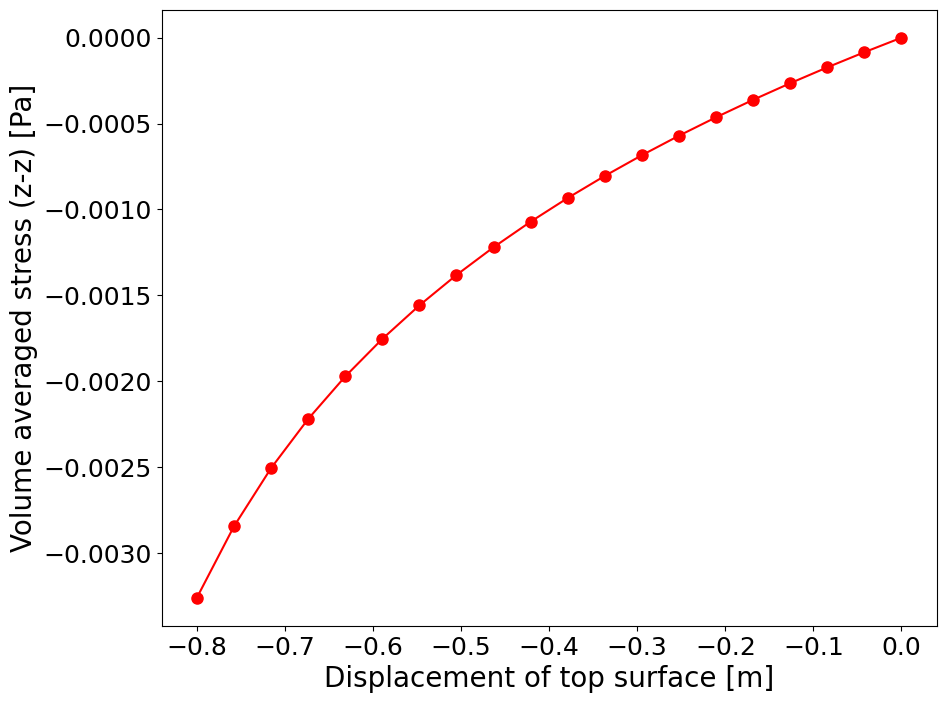

In [ ]:
# grain/aggregate params
# change 0 to s for solid or silicate
xi_crit = 8*1e-10 # critical rolling energy, 8 angstrom in m
rho_0 = 2.65 * 1e3 / 1e6 # silicate, g/cm^3 in kg/m^3
r0 = 0.1e-6 # monomer size, 0.1 micron in m
gamma = 20*1e3 # surface energy, mJ/m^2 in J/m^2
m0 = rho_0 * (4*np.pi)/3 * r0**3 # monomer mass in kg, silicate 
Eroll = 6*np.pi**2 * gamma * r0 * xi_crit # rolling energy 
phi_max = 0.78 # max volume filling factor

# material params
E_factor = 1.
nu = 0.05
rho_center = 0.01

# file path and name 
test_num = 'field-test' 
solver_type = 'jax_solver'
Nx, Ny, Nz = 10, 10, 10 # cells in a row
N_cells = Nx*Ny*Nz
steps = 20
deform = 0.8
dens = rho_center
name = '80' # deformation percentage
E_val = '1rho' # make this into an actual modifiable param
data_dir = os.path.join(os.path.dirname('/home/elouan/Compression/'), f'density-model-{test_num}_{name}_{solver_type}_{dens}_{E_val}')

# mesh generation
ele_type = 'HEX8' # first-order hexahedron element
cell_type = get_meshio_cell_type(ele_type)
Lx, Ly, Lz = 1., 1., 1.
meshio_mesh = box_mesh_gmsh(Nx=Nx, Ny=Ny, Nz=Nz, Lx=Lx, Ly=Ly, Lz=Lz, data_dir=data_dir, ele_type=ele_type)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])



# Find node coordinates located at the boundaries
def top(point):
    return np.isclose(point[2], Lz, atol=1e-5)

def bottom(point):
    return np.isclose(point[2], 0., atol=1e-5)

def center_x(point):
    return np.isclose(point[0], Lx/2, atol = 1e-2)

def center_y(point):
    return np.isclose(point[1], Ly/2, atol = 1e-2)

# def aggregate_center(point):
#     # return nodes belonging to the center of the cube, which is 8% of the total volume
#     center_cond = np.array([Lx/2, Ly/2,Lz/2])
#     return np.isclose(point, center_cond, atol = 1e-1)

# Define Dirichlet boundary values.
# We fix the z-component of the displacement field to be zero on the 'bottom' side and control the z-component on the 'top' side.
def dirichlet_val_bottom(point):
    return 0.

def get_dirichlet_top(disp):
    def val_fn(point):
        return disp
    return val_fn


def set_density(mesh, rho_center):
    """Generates a spherical density field with 1/r dependence for a mesh object. Normalised to rho_hi, the desired density in the center
    of the material.

    Args:
        problem (_type_): _description_

    Returns:
        float, tracer array-like: array of shape ((1000, 8)) with the initial density field
    """
    node_coords_cells = mesh.points[mesh.cells]
    cell_centers = np.mean(node_coords_cells, axis=1)
    material_center = np.mean(node_coords_cells)
    rvec = cell_centers-material_center

    # get norm of distance
    r = np.linalg.norm(rvec, axis = 1)

    # spherical density field
    rho_scaling_factor = 1/r
    max_rho_factor = np.max(rho_scaling_factor)
    cell_density = (rho_center/max_rho_factor) * rho_scaling_factor
    node_density = np.repeat(cell_density, 8).reshape((-1, 8))
    print(node_density[0])

    return node_density
    
def soundspeed(density):
    """Calculates the soundspeed for a 3D solid at each node in m/s as a function of density.

    Args:
        density (_type_): _description_

    Returns:
        _type_: _description_
    """
    E = E_factor*density # E = constant * density
    csp = np.sqrt((E*(1-nu)/(density*(1-2*nu)))) # soundspeed in a 3D solid

    return csp

# Set Dirichlet conditions
disps = np.linspace(0.,-deform,steps) # compression in the z-dir
location_fns = [center_x, center_y, bottom, top]
value_fns = [dirichlet_val_bottom]*3 + [get_dirichlet_top(disps[0])]
vecs = [0, 1, 2, 2]

dirichlet_bc_info = [location_fns, vecs, value_fns]


# Set density field
# this is so bad and prone to errors! But I need it for now to handle the cell volume being < 1.
density_init = set_density(mesh, rho_center)/(Nx * Ny * Nz)
args = [density_init, E_factor, nu]

# Initialise problem
problem = Plasticity(mesh, vec=3, dim=3, dirichlet_bc_info=dirichlet_bc_info, additional_info=args)
print(problem.density.shape)
avg_stresses = []
cell_vols = []
mat_vol = []
csps = []


# Solve the problem
for i, disp in enumerate(disps):
    print(f"\nStep {i} in {len(disps)}, disp = {disp}")

    # update boundary conditions and density field
    dirichlet_bc_info[-1][-1] = get_dirichlet_top(disp)
    problem.fe.update_Dirichlet_boundary_conditions(dirichlet_bc_info)

    # solve problem
    sol_list = solver(problem, solver_options={f'{solver_type}': {}})

    # save data: deformation and density
    # to-do: add density to the file saver
    vtk_path = os.path.join(data_dir, f'vtk/sol_{i:03d}.vtu')
    vtk_rho_path = os.path.join(data_dir, f'vtk/rho_{i:03d}.vtu')
    cell_mean_densities = np.mean(problem.density, axis=1)
    save_sol(problem.fe, sol_list[0], vtk_path, cell_infos = [['density',cell_mean_densities]])
    

    # retrieve coordinates of the nodes grouped per cell
    coords_cell_nodes = problem.fe.points[problem.fe.cells] + sol_list[0][problem.fe.cells]

    # compute cell volumes with ConvexHull
    cell_volume = np.zeros(N_cells)
    for i in range(N_cells):
        points = coords_cell_nodes[i]
        hull = ConvexHull(points)
        # cell volumes in this iteration
        cell_volume = cell_volume.at[i].set(hull.volume) # simple item assignement doesn't work with jax aparently, hence this code line instead

    # save volumes for each iteration to a list
    cell_vols.append(cell_volume)
    mat_vol = np.sum(cell_volume)

    # uniform density
    # density = np.repeat(density_init[0]*(1/cell_volume), 8).reshape((-1, 8))
    
    # calculate new density field
    cell_volume = np.repeat(cell_volume, 8).reshape((-1, 8))
    new_density = density_init*(1/cell_volume)
    # print(cell_volume.shape)
    # print(new_density.shape)
    # print(new_density[0], new_density[970])

    # calculate soundspeed with new density
    csp = soundspeed(new_density)
    csps.append(csp)

    # update the stress, strain and density with the solution
    problem.update_stress_strain_density(sol_list[0], new_density)
    avg_stress = problem.compute_avg_stress()
    avg_stresses.append(avg_stress)

    
avg_stresses = np.array(avg_stresses)


# Plot the volume-averaged stress versus the vertical displacement of the top surface.
fig = plt.figure(figsize=(10, 8))
plt.plot(disps, avg_stresses[:, 2, 2], color='red', marker='o', markersize=8, linestyle='-') 
plt.xlabel(r'Displacement of top surface [m]', fontsize=20)
plt.ylabel(r'Volume averaged stress (z-z) [Pa]', fontsize=20)
plt.tick_params(labelsize=18)
plt.savefig(f"./density-model-{test_num}_{name}_{solver_type}_{dens}_{E_val}/stress-strain-{test_num}.png")
plt.show()




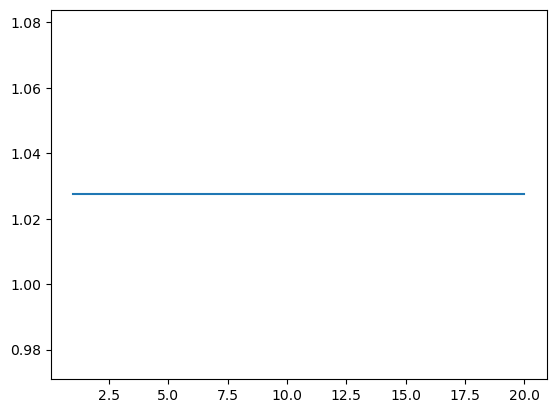

In [28]:
csps = np.array(csps)
csps[:,0,0]

plt.plot(np.arange(1,21), csps[:,970,0])


## Misc. and old code
Why do the volumes stay the same throughout the deformation? Checked cell coordinates of the first cell, and they don't change --> the mesh doesn't warp thoughout the sim.

Update: it works! I have the densities now :3

In [ ]:
# # 1/r density field
# """ why should density be defined on each node? (each cell has it's own set of nodes, they don't share them) """
# foo_dens = np.zeros((len(problem.fe.cells), problem.fe.num_quads))
# print(foo_dens.shape)
# coords_cell_nodes = problem.fe.points[problem.fe.cells]

# # THIS DETERMINES THE DENSITY BASED ON The cell center
# cell_centers=np.mean(coords_cell_nodes,axis=1)
# material_center=np.mean(coords_cell_nodes)
# rvec=cell_centers-material_center


# #jax.vmap(np.linalg.norm)(rvec)
# r=np.linalg.norm(rvec,axis=1)

# # spherical density field which drops of as 1/r
# density_init=1/r

# # Uniform density field
# rho_lo = 0.0001
# rho_hi = 0.01

# density_uni = [rho_lo* 1/(Nx * Ny * Nz), rho_hi * 1/(Nx * Ny * Nz)] # the extra factor is so that this will be the actual density, not the density x a factor from the grid size
# density_uni_init = [rho_lo* 1/(Nx * Ny * Nz), rho_hi* 1/(Nx * Ny * Nz)] 
# args = [density_uni_init]

# # Cell volumes
# coords_cell_nodes = problem.fe.points[problem.fe.cells]

# cell_vols = np.zeros(N_cells)
# for i in range(N_cells):
#     points = coords_cell_nodes[i]
#     hull = ConvexHull(points)
#     cell_vols = cell_vols.at[i].set(hull.volume) # simple item assignement doesn't work with jax aparently, hence this code line instead